In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import lab2rgb, rgb2lab
import sys
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

In [11]:
# representative RGB colours for each label, for nice display
COLOUR_RGB = {
    'red': (255, 0, 0),
    'orange': (255, 114, 0),
    'yellow': (255, 255, 0),
    'green': (0, 230, 0),
    'blue': (0, 0, 255),
    'purple': (187, 0, 187),
    'brown': (117, 60, 0),
    'pink': (255, 187, 187),
    'black': (0, 0, 0),
    'grey': (150, 150, 150),
    'white': (255, 255, 255),
}
name_to_rgb = np.vectorize(COLOUR_RGB.get, otypes=[np.uint8, np.uint8, np.uint8])

In [12]:
def plot_predictions(model, lum=71, resolution=256):
    """
    Create a slice of LAB colour space with given luminance; predict with the model; plot the results.
    """
    wid = resolution
    hei = resolution
    n_ticks = 5

    # create a hei*wid grid of LAB colour values, with L=lum
    ag = np.linspace(-100, 100, wid)
    bg = np.linspace(-100, 100, hei)
    aa, bb = np.meshgrid(ag, bg)
    ll = lum * np.ones((hei, wid))
    lab_grid = np.stack([ll, aa, bb], axis=2)

    # convert to RGB for consistency with original input
    X_grid = lab2rgb(lab_grid)

    # predict and convert predictions to colours so we can see what's happening
    y_grid = model.predict(X_grid.reshape((wid*hei, 3)))
    pixels = np.stack(name_to_rgb(y_grid), axis=1) / 255
    pixels = pixels.reshape((hei, wid, 3))

    # plot input and predictions
    plt.figure(figsize=(10, 5))
    plt.suptitle('Predictions at L=%g' % (lum,))
    plt.subplot(1, 2, 1)
    plt.title('Inputs')
    plt.xticks(np.linspace(0, wid, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.yticks(np.linspace(0, hei, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.xlabel('A')
    plt.ylabel('B')
    plt.imshow(X_grid.reshape((hei, wid, 3)))

    plt.subplot(1, 2, 2)
    plt.title('Predicted Labels')
    plt.xticks(np.linspace(0, wid, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.yticks(np.linspace(0, hei, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.xlabel('A')
    plt.imshow(pixels)

model_rgb accuracy: 0.5364372469635628
model_lab accuracy: 0.6072874493927125


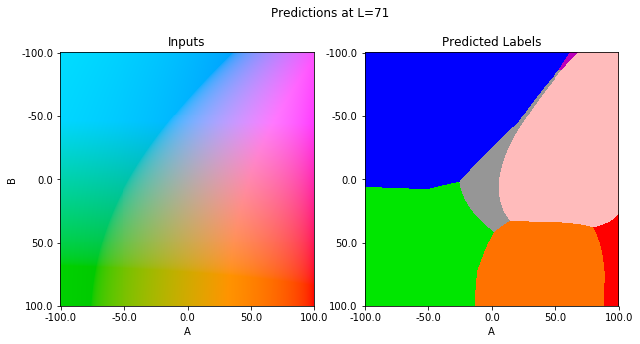

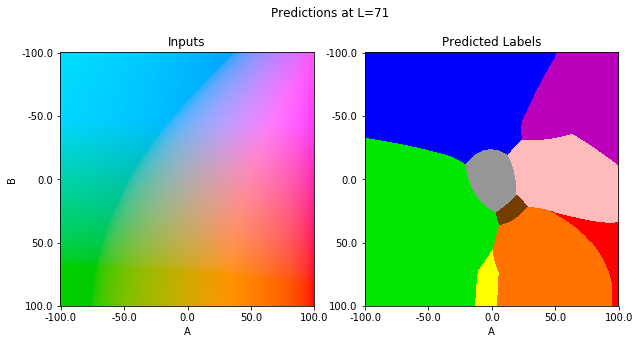

In [13]:
def main(infile):
    data = pd.read_csv(infile)
    X = data[['R', 'G', 'B']]/255 # array with shape (n, 3). Divide by 255 so components are all 0-1.
    y = data[['Label']] # array with shape (n,) of colour words.
    
    # 3/4 -> train, 1/4 -> test
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    # TODO: build model_rgb to predict y from X.
    model_rgb = GaussianNB()
    model_rgb.fit(X_train, y_train.values.ravel())
    # TODO: print model_rgb's accuracy score
    print('model_rgb accuracy: {}'.format(model_rgb.score(X_test, y_test.values.ravel())))
    
    # TODO: build model_lab to predict y from X by converting to LAB colour first.
    # DONE
    def convert_to_lab(X):
        X = np.array(X).reshape(1,-1,3)
        return rgb2lab(X).reshape(-1,3)
    model_lab = make_pipeline(
        FunctionTransformer(convert_to_lab, validate=True),
        GaussianNB()
    )
    model_lab.fit(X_train, y_train.values.ravel())
    
    # TODO: print model_lab's accuracy score
    print('model_lab accuracy: {}'.format(model_lab.score(X_test, y_test.values.ravel())))
    plot_predictions(model_rgb)
    plt.savefig('predictions_rgb.png')
    plot_predictions(model_lab)
    plt.savefig('predictions_lab.png')


if __name__ == '__main__':
    main(sys.argv[1] if len(sys.argv) == 2 else 'colour-data.csv')